In [1]:
import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read Data

In [2]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

print(pd.DataFrame([[len(data_et)], [len(data_trial)], [len(data_subject)]], 
                   columns=['length'],
                   index=['data_et', 'data_trial', 'data_subject'])
     )

              length
data_et       741751
data_trial     36739
data_subject      94


# Window Size

In [3]:
def addWindowSize(data):
    grouped = data \
        .groupby(["run_id", "subject"])["window_width", "window_height"].max() \
        .reset_index()
    grouped.columns = ["run_id", "subject", "window_width_max", "window_height_max"]
    grouped['window_diagonal_max'] = np.sqrt(grouped['window_width_max']**2 + grouped['window_height_max']**2)
    if "window_width_max" in data.columns: 
        data = data.drop(columns=['window_width_max'])
    if "window_height_max" in data.columns: 
        data = data.drop(columns=['window_height_max'])
    if "window_diagonal_max" in data.columns: 
        data = data.drop(columns=['window_diagonal_max'])
    data = data.merge(grouped, on=['run_id', "subject"], how='left')
    return data

data_trial = addWindowSize(data_trial)
data_trial['window_diagonal'] =  np.sqrt(data_trial['window_width']**2 + data_trial['window_height']**2)

<ipython-input-3-1351852b2457>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data \


# Trial Duration

In [4]:
def checkTimeDeviation(data, column1, column2, maxTimeDiffAllowed):
    diff = data[column1] - data['trial_duration_exact']
    longtrials_runID = data.loc[diff[diff > maxTimeDiffAllowed].index, 'run_id']
    longtrials_previousrunID = pd.DataFrame(data.loc[diff[diff > maxTimeDiffAllowed].index-1, 'run_id']) \
        .rename(columns={'run_id':'previous_run_id'})
    longtrials_previousrunID.index = longtrials_runID.index
    compare_runIDs = pd.concat([longtrials_runID, longtrials_previousrunID], axis=1)

    if sum(compare_runIDs['run_id'] == compare_runIDs['previous_run_id']) > 0: 
        print(column1 + ' and ' + column2 + ' show a deviation of ' +
              '>' + str(maxTimeDiffAllowed) + 
              ' ms. Please check on the following indices: \n')
        print(compare_runIDs.loc[(compare_runIDs['run_id'] == compare_runIDs['previous_run_id']), :].index)

    else:
        print('Success! ' + column1 + ' and ' + column2 + ' do not deviate by ' +
              '>' + str(maxTimeDiffAllowed) + 'ms.')
        
def exactTrialDuration(data):
    data["t_startTrial"] = pd.concat([pd.Series([0]), data["time_elapsed"]], ignore_index=True)
    data["trial_duration_exact"] = data.loc[:, ("time_elapsed")] - data.loc[:, ("t_startTrial")]
    data.drop(len(data)-1)
    
    checkTimeDeviation(data, 'rt', 'trial_duration_exact', 50)
    checkTimeDeviation(data, 'trial_duration', 'trial_duration_exact', 50)
    
    return data

data_trial = exactTrialDuration(data_trial)

Success! rt and trial_duration_exact do not deviate by >50ms.
Success! trial_duration and trial_duration_exact do not deviate by >50ms.


# Identify fixation task

In [5]:
data_trial['fixTask'] = 0

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') & 
    (data_trial['trial_duration']==5000),
    'fixTask'
] = 1
data_trial['fixTask'].unique()

array([0, 1], dtype=int64)

# withinTaskIndex

In [6]:
data_trial.loc[
    (data_trial['run_id']==103) &
    (data_trial['task_nr']==1), 
    :
]

,run_id,subject,prolificID,chinFirst,trial_index,trial_type,task_nr,rt,stimulus,key_press,...,option_bottomRight,chosenAmount,chosenDelay,window_width_max,window_height_max,window_diagonal_max,window_diagonal,t_startTrial,trial_duration_exact,fixTask
622,103,153.0,600063f2943eab0acc812ed8,0.0,105.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,601932.0,1529.0,0
623,103,153.0,600063f2943eab0acc812ed8,0.0,106.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,603461.0,5052.0,1
625,103,153.0,600063f2943eab0acc812ed8,0.0,108.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,610021.0,1502.0,0
626,103,153.0,600063f2943eab0acc812ed8,0.0,109.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,611523.0,5065.0,1
628,103,153.0,600063f2943eab0acc812ed8,0.0,111.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,618097.0,1510.0,0
629,103,153.0,600063f2943eab0acc812ed8,0.0,112.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,619607.0,5050.0,1
631,103,153.0,600063f2943eab0acc812ed8,0.0,114.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,626165.0,1542.0,0
632,103,153.0,600063f2943eab0acc812ed8,0.0,115.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,627707.0,5070.0,1
634,103,153.0,600063f2943eab0acc812ed8,0.0,117.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,634286.0,1521.0,0
635,103,153.0,600063f2943eab0acc812ed8,0.0,118.0,eyetracking-fix-object,1.0,NaN,"""",NaN,...,"""",$4.5,180 days,1536.0,864.0,1762.325736,1762.325736,635807.0,5059.0,1


In [7]:
def withinTaskIndex(data): 
    allTrialIndices = []
    for subject in data["run_id"].unique():
        df_subj = data.loc[data['run_id']==subject, :]

        for trial_type in df_subj['trial_type'].unique():
            df_trial = df_subj.loc[df_subj['trial_type']==trial_type, :]
            
            for task_nr in df_trial["task_nr"].unique():
                df_task = df_trial.loc[df_trial['task_nr']==task_nr, :]
                        
                for fixTask in df_task['fixTask'].unique():
                    df_fixTask = df_task.loc[
                        df_task['fixTask']==fixTask,  
                        ['run_id', 'trial_index']] \
                    .drop_duplicates() \
                    .reset_index(drop=True)
        
                    df_fixTask['withinTaskIndex'] = df_fixTask.index + 1
                    allTrialIndices.append(df_fixTask)
    allTrialIndices = pd.concat(allTrialIndices).reset_index(drop=True)
    return allTrialIndices

def addWithinTaskIndex(data):
    newIndices = withinTaskIndex(data)
    if 'withinTaskIndex' in data.columns: data = data.drop(columns=['withinTaskIndex'])
    data = data.merge(newIndices, on = ['run_id', 'trial_index'], how = 'left')
    return data

data_trial = addWithinTaskIndex(data_trial)

In [8]:
data_trial.loc[
    (data_trial['run_id']==1) &
    (data_trial['trial_type']=='eyetracking-choice'), 
    ['run_id', 'trial_index', 'task_nr', 
     'trial_type',
     'fixTask', 'withinTaskIndex']
]

,run_id,trial_index,task_nr,trial_type,fixTask,withinTaskIndex
144,1,145.0,2.0,eyetracking-choice,0,1.0
147,1,148.0,2.0,eyetracking-choice,0,2.0
150,1,151.0,2.0,eyetracking-choice,0,3.0
153,1,154.0,2.0,eyetracking-choice,0,4.0
156,1,157.0,2.0,eyetracking-choice,0,5.0
...,...,...,...,...,...,...
370,1,371.0,2.0,eyetracking-choice,0,76.0
373,1,374.0,2.0,eyetracking-choice,0,77.0
376,1,377.0,2.0,eyetracking-choice,0,78.0
379,1,380.0,2.0,eyetracking-choice,0,79.0


# fps

## trial_level

In [9]:
def merge_count_by_index(data, large_data, varName):
    if varName + '_count' in data.columns: data = data.drop(columns=[varName + '_count'])
    grouped = large_data.groupby(["run_id", "trial_index"])[varName].count() \
        .reset_index() \
        .rename(columns={varName: varName + '_count'})
    data = data.merge(grouped, on=["run_id", "trial_index"], how='left')
    return(data)

data_trial = merge_count_by_index(data_trial, data_et, 'x')

data_trial['fps'] = 1000 * data_trial['x_count'] / data_trial['trial_duration_exact']
data_trial['fps'].describe()

count    17786.000000
mean        14.975152
std          7.668486
min          0.072031
25%         10.173092
50%         15.302728
75%         19.486535
max         47.811837
Name: fps, dtype: float64

In [10]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

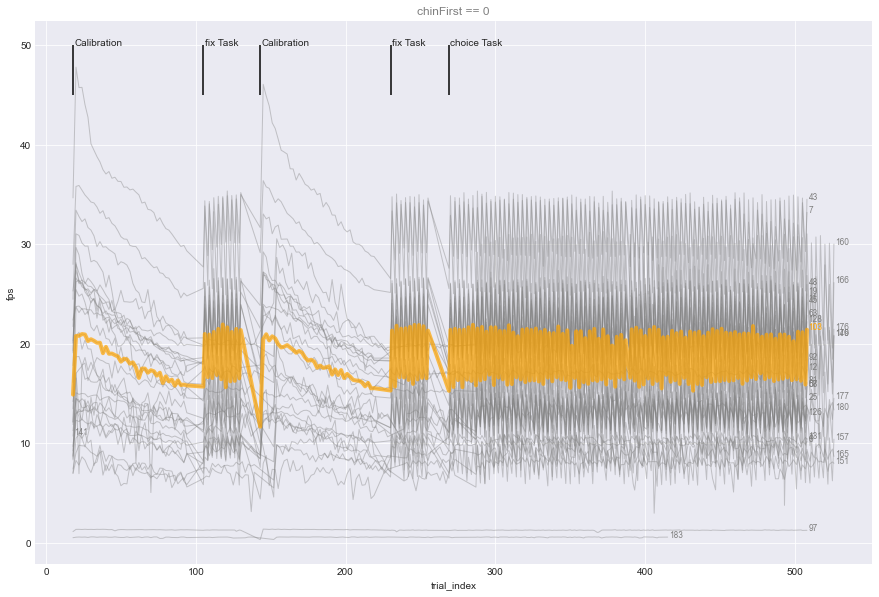

In [11]:
spaghettiPlot(
    data_trial.loc[(data_trial['chinFirst']==0) & pd.notna(data_trial['fps']), :], 
    'trial_index', 'fps', 103
)
plt.title('chinFirst == 0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(143, 45, 50, colors='k', linestyles='solid')
plt.text(143+1, 50, s='Calibration')
plt.vlines(230, 45, 50, colors='k', linestyles='solid')
plt.text(230+1, 50, s='fix Task')
plt.vlines(269, 45, 50, colors='k', linestyles='solid')
plt.text(269+1, 50, s='choice Task')
plt.show()

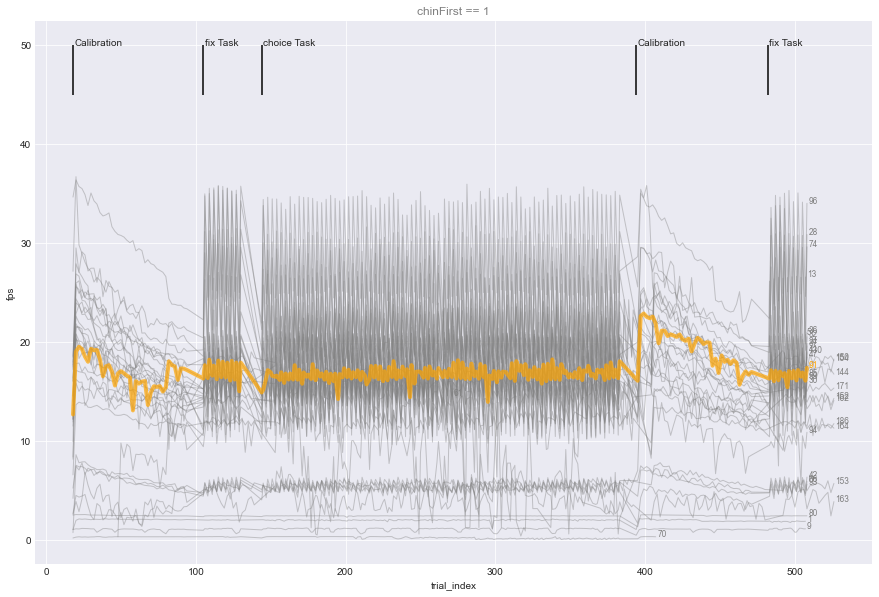

In [12]:
spaghettiPlot(
    data_trial.loc[(data_trial['chinFirst']==1) & pd.notna(data_trial['fps']), :], 
    'trial_index', 'fps', 91
)
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(144, 45, 50, colors='k', linestyles='solid')
plt.text(144+1, 50, s='choice Task')
plt.vlines(394, 45, 50, colors='k', linestyles='solid')
plt.text(394+1, 50, s='Calibration')
plt.vlines(482, 45, 50, colors='k', linestyles='solid')
plt.text(482+1, 50, s='fix Task')
plt.show()

## subject-level

(array([ 5.,  2.,  4.,  2.,  7.,  4., 10.,  9.,  6.,  9.,  4.,  2.,  0.,
         2.,  1.]),
 array([ 0.28354317,  2.43260903,  4.5816749 ,  6.73074076,  8.87980663,
        11.02887249, 13.17793836, 15.32700422, 17.47607009, 19.62513595,
        21.77420182, 23.92326768, 26.07233355, 28.22139941, 30.37046527,
        32.51953114]),
 <BarContainer object of 15 artists>)

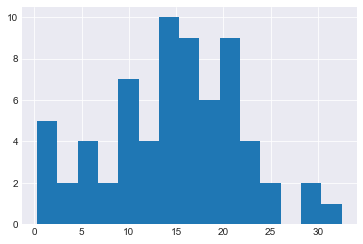

In [13]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial, 'fps')
plt.hist(data_subject['fps'], bins=15)

# subject data

In [14]:
data_subject

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,entered_code,Country of Birth,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status,Webcam,fps
0,1,1995.0,0.0,Chrome,87.0.4280.141,high,WebKit,caucasian,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.030567
1,103,2001.0,0.0,Chrome,87.0.4280.141,college,WebKit,caucasian,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.522002
2,106,NaN,NaN,Chrome,87.0.4280.141,NaN,WebKit,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,108,NaN,NaN,Chrome,87.0.4280.77,NaN,iPhone,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,1991.0,0.0,Chrome,87.0.4280.141,college,WebKit,asian,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.456080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,94,1998.0,0.0,Chrome,87.0.4280.109,grad,WebKit,black,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.185343
90,96,1997.0,0.0,Chrome,87.0.4280.141,college,WebKit,caucasian,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.484625
91,97,1988.0,0.0,Chrome,87.0.4280.141,NaN,Macintosh,caucasian,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.271814
92,98,1996.0,0.0,Firefox,84.0,NaN,NaN,caucasian,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data_subject['degree'] = data_subject['degree'].astype('category')
data_subject['degree'].cat.reorder_categories(['middle', 'high', 'college', 'grad'], inplace=True)
data_subject['degree']

ValueError: items in new_categories are not the same as in old categories

In [ ]:
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [ ]:
data_subject['optionalNote'].unique()

In [ ]:
for col in ['Nationality', 'Employment Status', 'webcam_fps', 'ethnic', 'gender']:
    print(pd.crosstab(index=data_subject[col],
                      columns="count")
         )
    print('\n')

# Export data

In [ ]:
data_trial.to_csv("data_jupyter/data_trial.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [ ]:
print('Success! Script ran through')